In [ ]:
from google.colab import drive
drive.mount('/GD')

Mounted at /GD


In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk import word_tokenize

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install "tensorflow==1.15"

     |████████████████████████████████| 412.3MB 38kB/s 
     |████████████████████████████████| 512kB 54.7MB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=d2e295800b1441d04e64d090af517640325de8f4b8d13d989a706d07cbb0a229
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
import tensorflow as tf  

In [ ]:
tf.__version__

'1.15.0'

In [ ]:
# load packages
from sklearn import metrics,preprocessing,model_selection
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
spacy.load('en')
parser = English()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install tensorflow-hub
import tensorflow_hub as hub

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [ ]:
data = pd.read_csv('/GD/MyDrive/Colab Notebooks/Data/dataset_hashtag.csv')

In [ ]:
data.head()

,id,text,label
0,1215996323318517761,b'RT @beingdeepak2k18: You are the most pure h...,0
1,1215996294625296384,b'RT @SoniyaS53052429: Aaj tk #BigBoss me kisi...,0
2,1215995880693628928,b'Sid ki chadii ka size din pa din chota hota ...,0
3,1215995494935089158,b'RT @beingdeepak2k18: You are the most pure h...,0
4,1215995243910156290,b'RT @ImRealBarfi: You have exposed #BB13 make...,0


In [ ]:
data.shape

(30000, 3)

In [ ]:
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
data['label'].value_counts()

6    5000
4    5000
2    5000
1    5000
0    4509
3    2797
5    1363
9     805
8     309
7     217
Name: label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


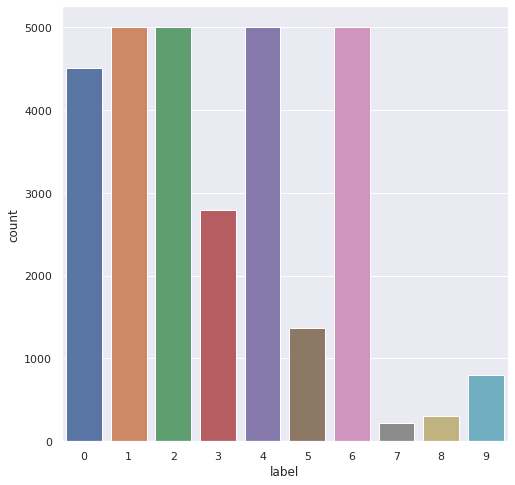

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(data['label'])

In [ ]:
# Stop words and special characters 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [ ]:
# Data Cleaner and tokenizer

def tokenizeText(text):
    
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    
    tokens = parser(text)
    
    # lemmatization
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # remove stop words and special charaters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    tokens = list(set(tokens))
    
    return ' '.join(tokens[:])

In [ ]:
# Data cleaning
data['text'] = data['text'].apply(lambda x:tokenizeText(x))

In [ ]:
data.head()

,id,text,label
0,1215996323318517761,innocence power amp heart hearted raw person p...,0
1,1215996294625296384,aaj nhi hua aware kya sir pyar bigboss kisi,0
2,1215995880693628928,size dekhte din bhi chadii raha hota families ...,0
3,1215995494935089158,innocence power amp heart hearted raw person p...,0
4,1215995243910156290,team exposed history editing bigboss know makers,0


In [ ]:
def encode(le_enc, labels):
    enc = le_enc.transform(labels)
    return tf.keras.utils.to_categorical(enc)
    
def decode(le_enc, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le_enc.inverse_transform(dec)

In [ ]:
# Data preparation
X = data['text'].tolist()
y = data['label'].tolist()

# Lebel encoding
le_enc = preprocessing.LabelEncoder()
le_enc.fit(y)

y_en = encode(le_enc, y)

In [ ]:
# split the dataset into training and testing datasets

x_train, x_test, y_train, y_test = model_selection.train_test_split(np.asarray(X), np.asarray(y_en), test_size=0.2, random_state=42)

In [ ]:
# ELMo Embedding
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
# Implement callback function to stop training
# when accuracy reaches ACCURACY_THRESHOLD
ACCURACY_THRESHOLD = 0.90

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('acc') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [ ]:
#Build model

# input_text = Input(shape=(1,), dtype=tf.string)
# embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
# dense = Dense(256, activation='relu')(embedding)
# pred = Dense(10, activation='softmax')(dense)
# model = Model(inputs=[input_text], outputs=pred)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# with tf.Session() as session:
#     K.set_session(session)
#     session.run(tf.global_variables_initializer())  
#     session.run(tf.tables_initializer())
#     history = model.fit(x_train, y_train, epochs=20, batch_size=16, callbacks=[callbacks])
#     model.save_weights('/GD/MyDrive/Colab Notebooks/SavedModel/multiclass-elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('/GD/MyDrive/Colab Notebooks/SavedModel/multiclass-elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=16)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# decode test labels
y_test = decode(le_enc, y_test)
# decode predicted labels
y_preds = decode(le_enc, predicts)

In [ ]:
print(metrics.confusion_matrix(y_test, y_preds))
print(metrics.confusion_matrix(y_test, y_preds).shape)

[[768  34  29   1  28   0  16   0   0   5]
 [  8 884  41  17  14   5  35   0   1   8]
 [ 12  58 856   7 102   1   2   0   1   8]
 [  2  17  11 489  20   4   3   1   1   6]
 [  4  19  41  27 847   1  25   0   2   7]
 [  0  32  29  14   8 185  11   0   0   0]
 [  0  85   9  35  48   2 770   0   6  42]
 [  0   1   1   0   3   0   0  40   0   1]
 [  0   2   1   1   1   0   0   0  37   2]
 [  2   3  12   4   6   0   5   0   0 134]]
(10, 10)


In [ ]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92       881
           1       0.78      0.87      0.82      1013
           2       0.83      0.82      0.82      1047
           3       0.82      0.88      0.85       554
           4       0.79      0.87      0.83       973
           5       0.93      0.66      0.78       279
           6       0.89      0.77      0.83       997
           7       0.98      0.87      0.92        46
           8       0.77      0.84      0.80        44
           9       0.63      0.81      0.71       166

    accuracy                           0.83      6000
   macro avg       0.84      0.83      0.83      6000
weighted avg       0.84      0.83      0.84      6000



In [ ]:
print("Accuracy of ELMO is:",accuracy_score(y_test,y_preds))

Accuracy of ELMO is: 0.835
